## As I will probably run many models, I will start to use MLFLow for control

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

train = pd.read_parquet("../data/processed/train_fs.parquet")
test = pd.read_parquet("../data/raw/test.parquet")

In [8]:
# VERSION NAME FOR SAVED MODEL FILES
VER = '02'

# TRAIN RANDOM SEED
SEED = 42

# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

# FOLDS PER MODEL
FOLDS = 5

# TRAIN FOLD
TRAIN_PATH = "../data/processed/train.parquet"

In [4]:
encoder = LabelEncoder()
for col in cat_cols:
    train[col]= encoder.fit_transform(train[col])
    test[col] = encoder.transform(test[col])

train = train.fillna(NAN_VALUE)

del train["S_2"]
train.head()

train.target = train.target.astype('int8')


### Competition metric

In [9]:
def amex_metric(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

### Model training

In [10]:
# FEATURES
FEATURES = train.columns[1:-1]
print(f'There are {len(FEATURES)} features!')

There are 165 features!


In [11]:
xgb_params = {
    'max_depth':4, 
    'learning_rate':0.05,
    'subsample': 0.8,
    'colsample_bytree':0.6,
    'eval_metric': 'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':42
}


### Version 02 - Kaggle Metric - 0.7466903183087572

In [12]:
importances = []
oof = []
TRAIN_SUBSAMPLE = 1.0

skf = KFold(n_splits = FOLDS, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train.target)):

    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
        
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)

    X_train = train.loc[train_idx, FEATURES]
    y_train = train.loc[train_idx, 'target']
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']

    dtrain = xgb.DMatrix(data= X_train, label=y_train)
    dvalid= xgb.DMatrix(data= X_valid, label= y_valid)
    
    model = xgb.train(
                    xgb_params,
                    dtrain=dtrain,
                    evals=[(dtrain, 'train'), (dvalid, 'valid')],
                    num_boost_round= 9999,
                    early_stopping_rounds = 100,
                    verbose_eval= 100
                    )

    model.save_model(f'../models/XGB_V{VER}_fold{fold}.xgb')

    dd = model.get_score(importance_type='weight')
    df= pd.DataFrame({'feature':dd.keys(), f'importance_{fold}':dd.values()})
    importances.append(df)

    oof_preds = model.predict(dvalid)
    acc = amex_metric(y_valid.values, oof_preds)
    print("Kaggle Metric=", acc,'\n')

    df = train.loc[valid_idx, ['customer_ID', 'target']].copy()
    df['oof_pred']= oof_preds
    oof.append(df)

    del dtrain, X_train, y_train, dd, df
    del X_valid, y_valid, dvalid, model

print('#'*25)
oof = pd.concat(oof, axis=0, ignore_index=True).set_index('customer_ID')
acc= amex_metric(oof.target.values, oof.oof_pred.values)
print('OVERAL CV Kaggle Metric = ', acc)


#########################
### Fold 1
### Train size 4425160 Valid size 1106291
### Training with 100% fold data...
#########################
[0]	train-logloss:0.66503	valid-logloss:0.66506
[100]	train-logloss:0.28560	valid-logloss:0.28574
[200]	train-logloss:0.27451	valid-logloss:0.27478
[300]	train-logloss:0.27027	valid-logloss:0.27073
[400]	train-logloss:0.26776	valid-logloss:0.26834
[500]	train-logloss:0.26607	valid-logloss:0.26680
[600]	train-logloss:0.26475	valid-logloss:0.26560
[700]	train-logloss:0.26361	valid-logloss:0.26459
[800]	train-logloss:0.26268	valid-logloss:0.26378
[900]	train-logloss:0.26182	valid-logloss:0.26303
[1000]	train-logloss:0.26102	valid-logloss:0.26235
[1100]	train-logloss:0.26029	valid-logloss:0.26174
[1200]	train-logloss:0.25966	valid-logloss:0.26122
[1300]	train-logloss:0.25905	valid-logloss:0.26074
[1400]	train-logloss:0.25848	valid-logloss:0.26027
[1500]	train-logloss:0.25795	valid-logloss:0.25985
[1600]	train-logloss:0.25740	valid-logloss:0.25942
[170

In [13]:
## Import up sound alert dependencies Play after long run
import IPython

IPython.display.Audio(filename="C:/Users/brito/OneDrive/Documentos/2 - Outros/Rigntones/The Legend of Zelda on Acoustic Guitar by GuitarGamer (Fabio Lima).mp3", autoplay=True)



In [15]:
df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'xgb_feature_importance_v{VER}.csv',index=False)

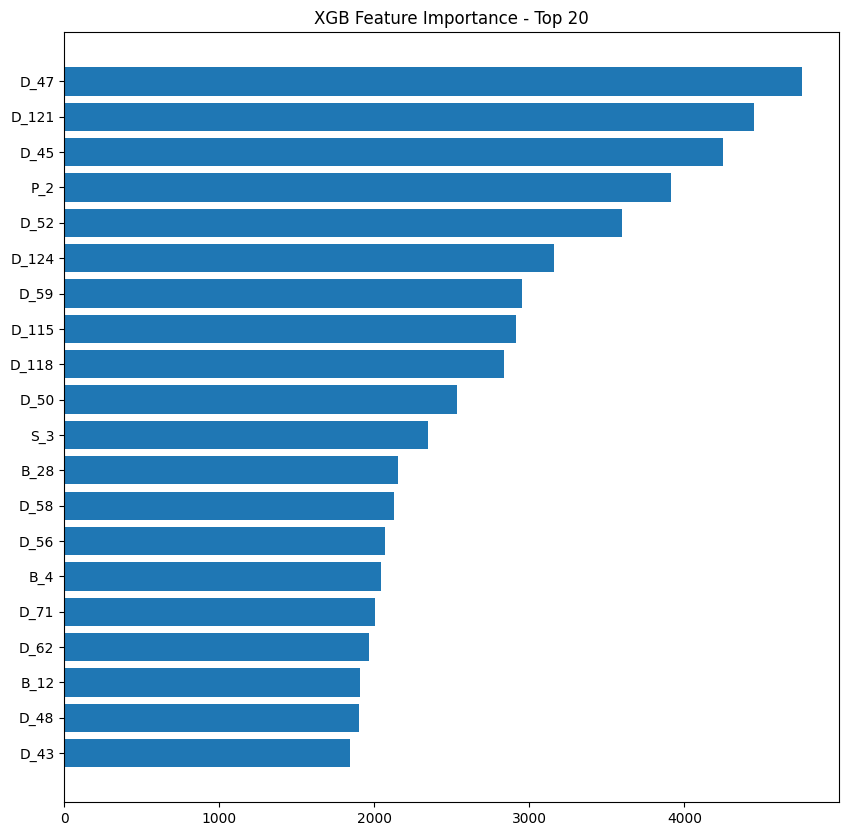

In [16]:

NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()